# Representational Geodesic

This notebook investigates the impact of L1 and L2 norm in representation space on a toy image (rectangle) on the generated images using different models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams['figure.dpi'] = 72
%matplotlib inline

import pyrtools as pt
import plenoptic as po
from plenoptic.tools import to_numpy
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
# this notebook uses torchvision, which is an optional dependency.
# if this fails, install torchvision in your plenoptic environment 
# and restart the notebook kernel.
try:
    import torchvision
except ModuleNotFoundError:
    raise ModuleNotFoundError("optional dependency torchvision not found!"
                              " please install it in your plenoptic environment "
                              "and restart the notebook kernel")
import torchvision.transforms as transforms
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32
torch.__version__

'2.3.1+cu121'

## Image sequence: Rotation

Rotated images shape: torch.Size([21, 1, 64, 64])


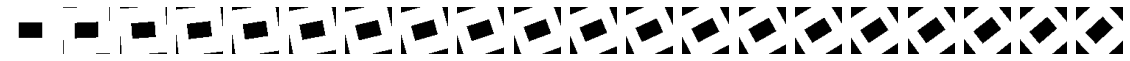

Image shape Start image: torch.Size([1, 1, 64, 64])


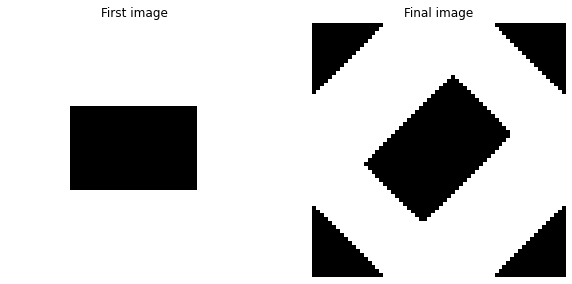

Image statistics:
Image statistics:
  Range: [0.000000, 1.000000]
  Mean: 0.835938,  Stdev: 0.370377,  Kurtosis: 4.289405
Image statistics:
  Range: [0.000000, 1.000000]
  Mean: 0.668213,  Stdev: 0.470912,  Kurtosis: 1.509773
(21, 64, 64)


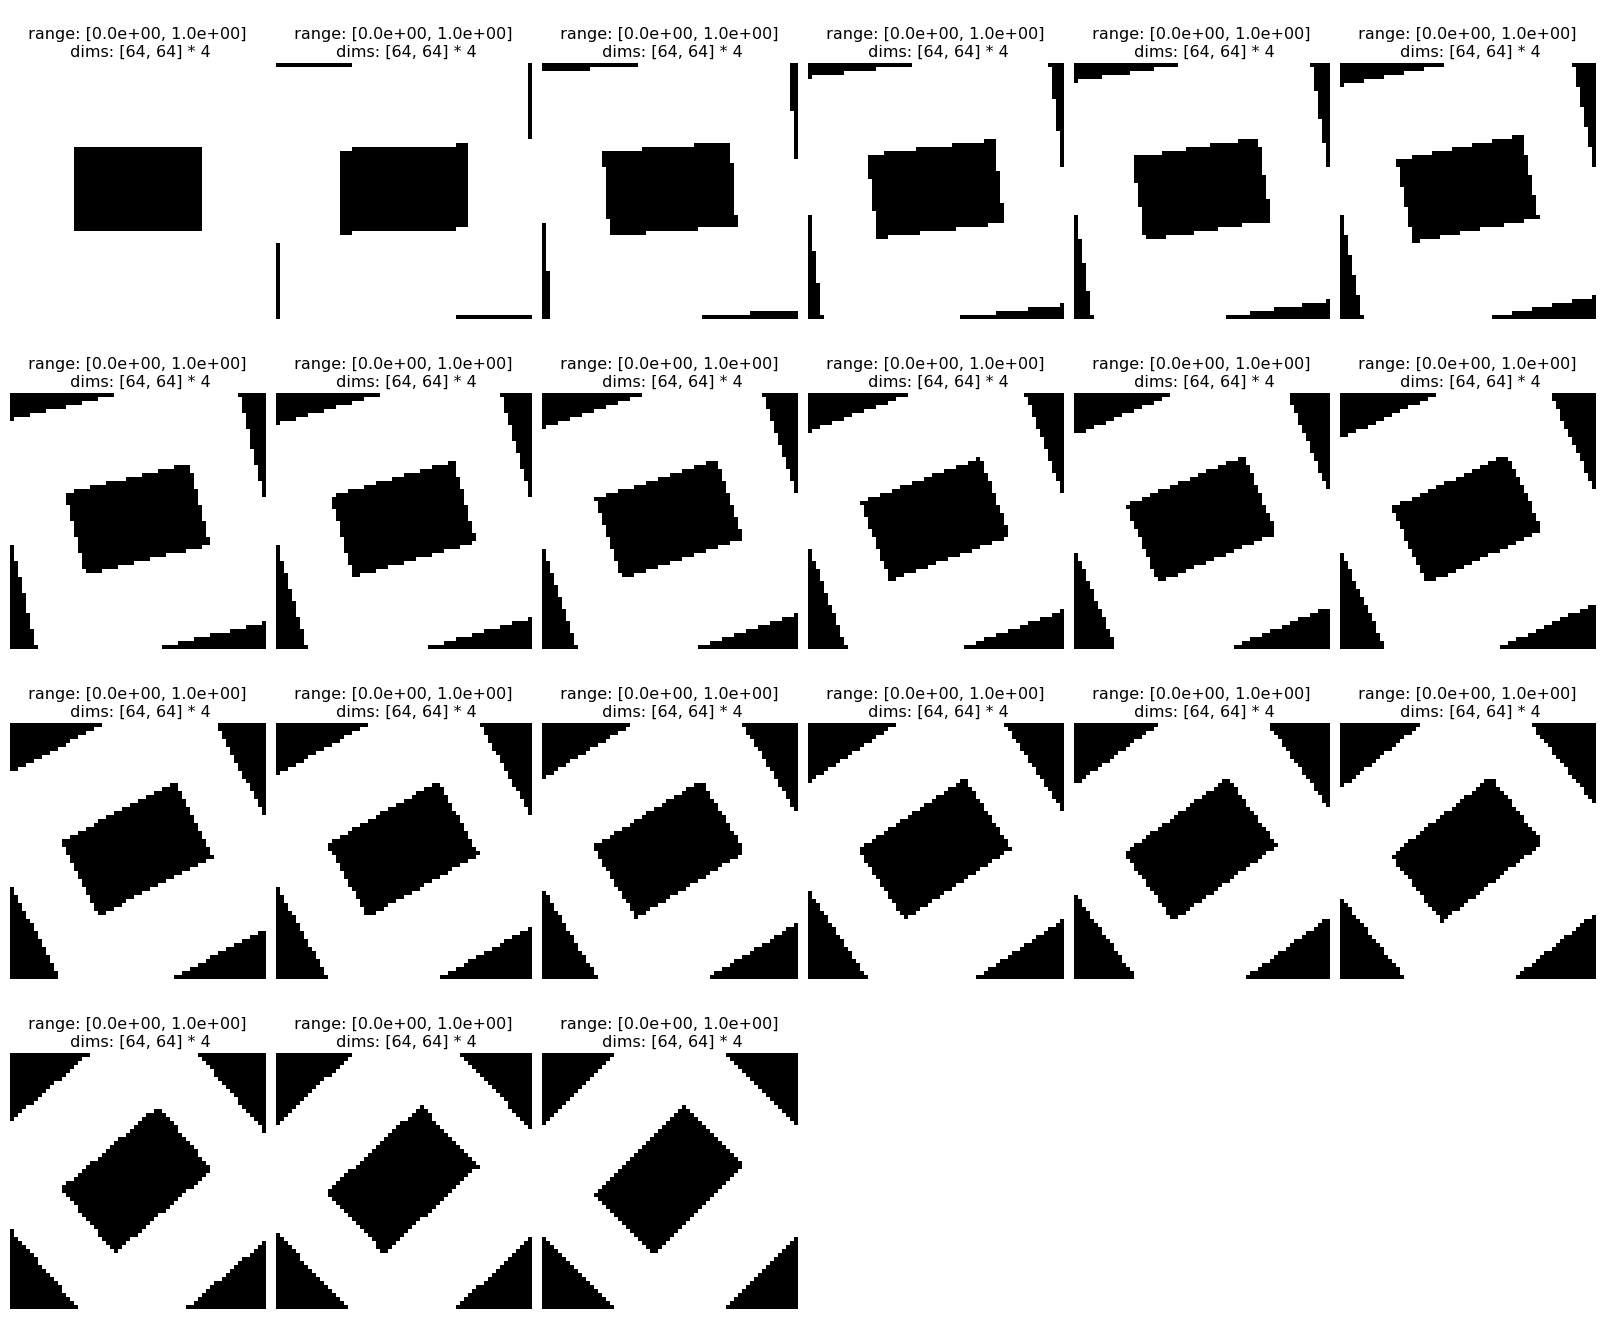

In [2]:
import torchvision.transforms.functional as TF

# Function to create the tensor with a black rectangle in the center
def create_image_tensor(height, width, rect_height, rect_width):
    tensor = torch.ones((1, 1, height, width))
    start_row = (height - rect_height) // 2
    start_col = (width - rect_width) // 2
    tensor[:, :, start_row:start_row + rect_height, start_col:start_col + rect_width] = 0
    return tensor

# Function to rotate the tensor and return the rotated tensor
def rotate_image_tensor(image_tensor, angle):
    image_pil = TF.to_pil_image(image_tensor.squeeze())
    rotated_image_pil = TF.rotate(image_pil, angle)
    rotated_image_tensor = TF.to_tensor(rotated_image_pil).unsqueeze(0).unsqueeze(0)
    return rotated_image_tensor

# Parameters
height = 64
width = 64
rect_height = height // 3
rect_width = width // 2
num_steps = 20
final_angle = 45

# Create the initial image tensor
image_tensor = create_image_tensor(height, width, rect_height, rect_width)

# Generate the sequence of rotated images
angles = np.linspace(0, final_angle, num_steps+1)
# a list of tensors with shape [1, 1, height, width]
rotated_images = [rotate_image_tensor(image_tensor, angle) for angle in angles] 
# create a batch of tensors with shape [num_steps, 1, 1, height, width]
rotated_images_tensor = torch.cat(rotated_images, dim=0).squeeze(1)
#print shape  
print("Rotated images shape:", rotated_images_tensor.shape)



# Display the sequence of rotated images
fig, axes = plt.subplots(1, num_steps, figsize=(20, 2))
for ax, rotated_image in zip(axes, rotated_images):
    ax.imshow(rotated_image.squeeze(), cmap='gray')
    ax.axis('off')

plt.show()
# print with plenoptic (includes range and dims info)
#pt.imshow(list(rotated_images_tensor.squeeze()), zoom=4, col_wrap=6);
rotated_images[0].shape
#vid = po.tools.center_crop(rotated_images_tensor, height // 2)
vid = po.tools.rescale(rotated_images_tensor, 0, 1)
# convention: full name for numpy arrays, short hands for torch tensors


# define first and final image of sequence
imgA = vid[0].unsqueeze(0)
# print shape
print("Image shape Start image:", imgA.shape)
imgB = vid[-1].unsqueeze(0)


# display first and final image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(imgA.squeeze(), cmap='gray')
axes[0].axis('off')
axes[0].set_title('First image')
axes[1].imshow(imgB.squeeze(), cmap='gray')
axes[1].axis('off')
axes[1].set_title('Final image')
plt.show()

# print image stats
print("Image statistics:")
pt.image_stats(to_numpy(imgA))
pt.image_stats(to_numpy(imgB))
video = to_numpy(vid).squeeze()
print(video.shape)
pt.imshow(list(video.squeeze()), zoom=4, col_wrap=6);


### Spectral models
Computing a geodesic to reveal excess invariance of the global Fourier magnitude representation.

In [3]:
import torch.fft
class Fourier(nn.Module):
    def __init__(self, representation = 'amp'):
        super().__init__()
        self.representation = representation
        
    def spectrum(self, x):
        return torch.fft.rfftn(x, dim=(2, 3))

    def forward(self, x):
        if self.representation == 'amp':
            return torch.abs(self.spectrum(x))
        elif self.representation == 'phase':
            return torch.angle(self.spectrum(x))
        elif self.representation == 'rectangular':
            return self.spectrum(x)
        elif self.representation == 'polar':
            return torch.cat((torch.abs(self.spectrum(x)),
                              torch.angle(self.spectrum(x))),
                             dim=1)

model = Fourier('amp')
# model = Fourier('polar') # note: need pytorch>=1.8 to take gradients through torch.angle 

In [17]:
n_steps = len(video)-1
loss_types = ['l1', 'l2']
geodesics = {}
optims = {}


def synthesize_geodesics(n_steps, model, loss_types=['l1', 'l2'], geodesics={}, optims={}):
    for loss_type in loss_types:
    # Generate the name for the Geodesic object based on the loss type
        geodesic_name = f'moog_{loss_type}'
        geodesics[geodesic_name] = po.synth.Geodesic(imgA, imgB, model, n_steps,initial_sequence='bridge', loss_type=loss_type)
    #geodesic_name = po.synth.Geodesic(imgA, imgB, model, n_steps, initial_sequence='bridge', loss_type=loss_type)
        optims[geodesic_name] = torch.optim.Adam([geodesics[geodesic_name]._geodesic], lr=.01, amsgrad=True)
        geodesics[geodesic_name].synthesize(max_iter=500, optimizer=optims[geodesic_name], store_progress=True)
    return geodesics, optims



In [18]:
geodesics

{}

In [19]:
geodesics, optims = synthesize_geodesics(n_steps=n_steps,model=model)



 Stop criterion for pixel_change_norm = 4.01006e-02


/mnt/home/hdettki/code/plenoptic/src/plenoptic/tools/validate.py:178: UserWarning: model is in training mode, you probably want to call eval() to switch to evaluation mode
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]


 Stop criterion for pixel_change_norm = 4.01006e-02


  0%|          | 0/500 [00:00<?, ?it/s]

/mnt/home/hdettki/code/plenoptic/src/plenoptic/synthesize/geodesic.py:209: UserWarning: Pixel change norm has converged, stopping synthesis
  warnings.warn("Pixel change norm has converged, stopping synthesis")


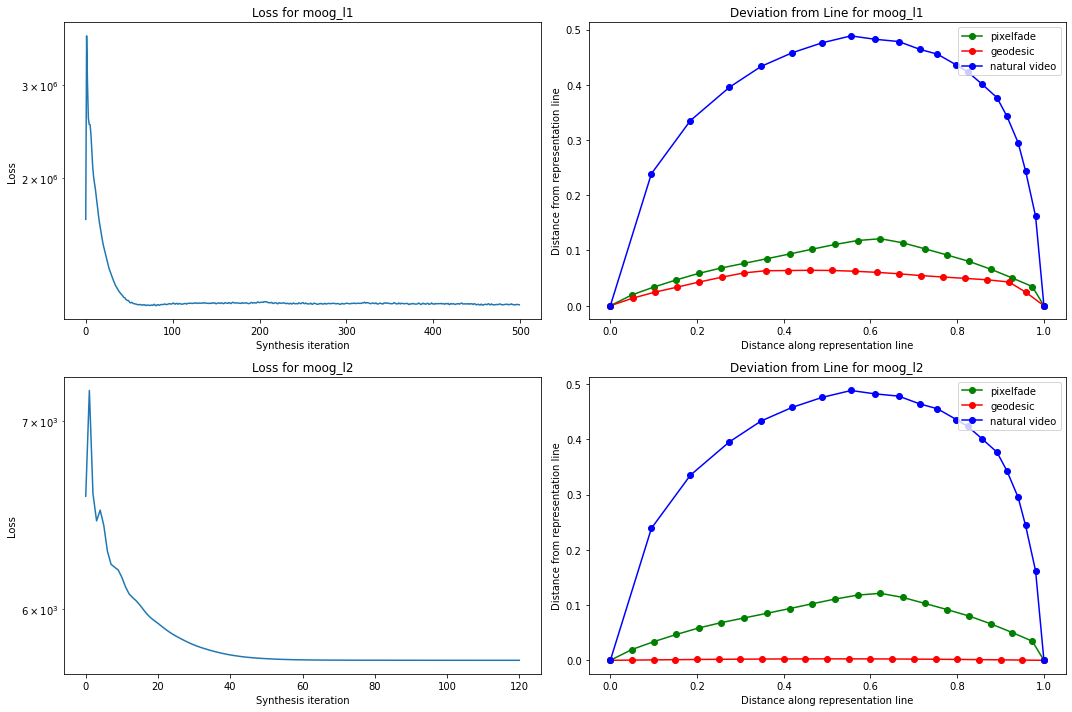

In [20]:
def plotLossAndDeviation(geodesics, vid, model, n_steps, loss_types, optims, imgA, imgB):
    # Number of loss types
    num_loss_types = len(loss_types)

# Create a figure with subplots - two plots for each loss type (loss and deviation)
    fig, axes = plt.subplots(nrows=num_loss_types, ncols=2, figsize=(15, 5 * num_loss_types))

# Check if there is only one type to adjust the indexing
    if num_loss_types == 1:
        axes = [axes]  # This makes indexing consistent below

    for i, (key, geodesic) in enumerate(geodesics.items()):
    # `key` would be 'moog_l1', 'moog_l2', etc.
    # Plot loss on the first column of the current row
        po.synth.geodesic.plot_loss(geodesic, ax=axes[i][0])
        axes[i][0].set_title(f'Loss for {key}')

    # Plot deviation from line on the second column of the current row
        po.synth.geodesic.plot_deviation_from_line(geodesic, vid, ax=axes[i][1])
        axes[i][1].set_title(f'Deviation from Line for {key}')

    plt.tight_layout()
    plt.show()

plotLossAndDeviation(geodesics=geodesics, vid=vid, model=model, n_steps=n_steps, loss_types=loss_types, optims=optims, imgA=imgA, imgB=imgB)    

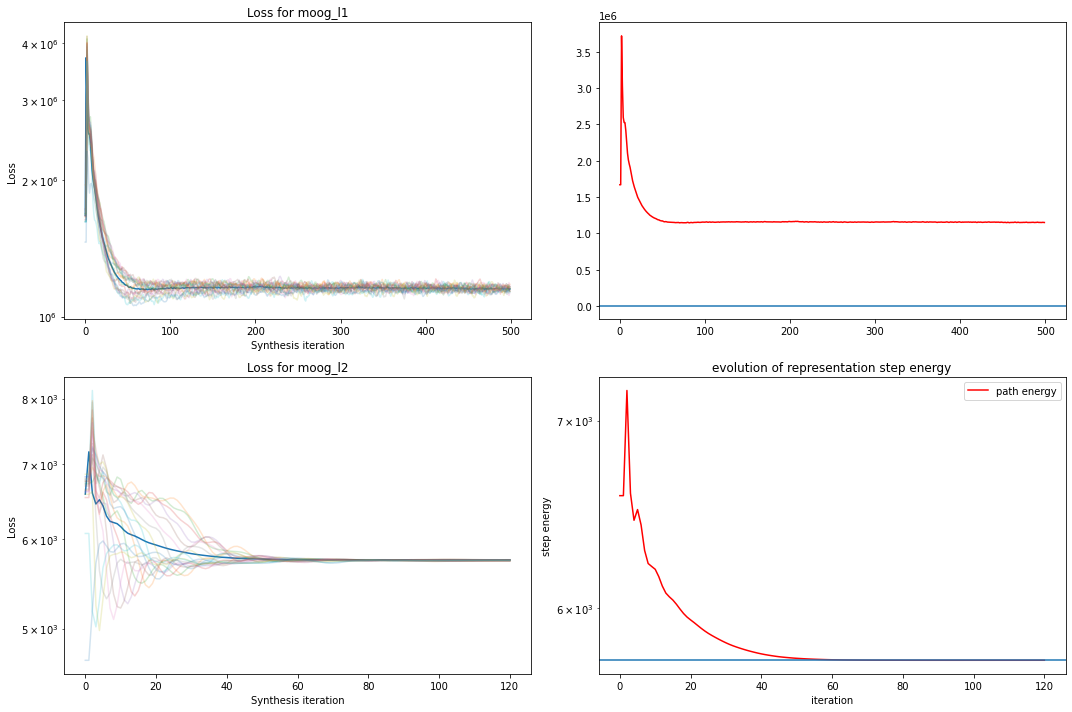

In [21]:
def plotLossAndEvolution(geodesics=geodesics, vid=vid, model=model, n_steps=n_steps, loss_types=loss_types, optims=optims, imgA=imgA, imgB=imgB):
    num_loss_types = len(loss_types)
    fig, axes = plt.subplots(nrows=num_loss_types, ncols=2, figsize=(15, 5 * num_loss_types))

# Check if there is only one type to adjust the indexing
    if num_loss_types == 1:
        axes = [axes]  # This makes indexing consistent below

    for i, (key, geodesic) in enumerate(geodesics.items()):
    # `key` would be 'moog_l1', 'moog_l2', etc.
    # Plot loss on the first column of the current row
        po.synth.geodesic.plot_loss(geodesic, ax=axes[i][0])
        axes[i][0].plot(po.to_numpy(geodesic.step_energy), alpha=.2)
        axes[i][0].set_title(f'Loss for {key}')
    # plot the path energy in the second column of the current row
        axes[i][1].plot(geodesic.step_energy.mean(1), 'r-', label='path energy')
        axes[i][1].axhline(torch.linalg.vector_norm(geodesic.model(geodesic.image_a) - geodesic.model(geodesic.image_b), ord=2) ** 2 / geodesic.n_steps ** 2)


    plt.legend()
    plt.title('evolution of representation step energy')
    plt.ylabel('step energy')
    plt.xlabel('iteration')
    plt.yscale('log')


    plt.tight_layout()
    plt.show()

plotLossAndEvolution()

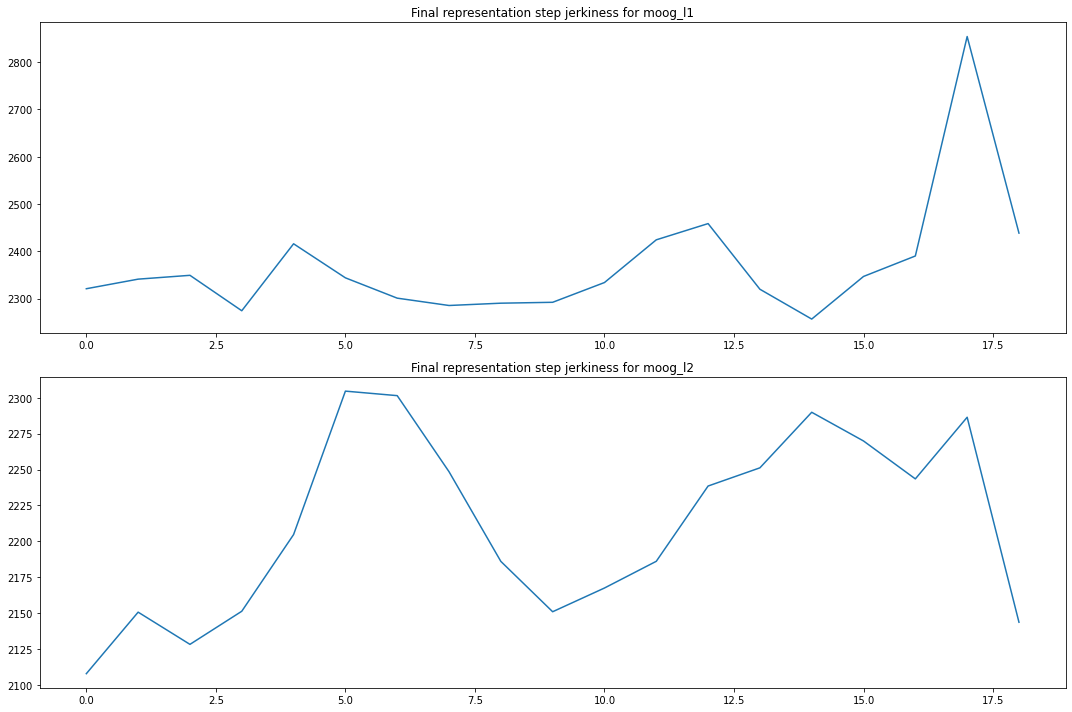

In [22]:
def plotJerkiness(geodesics=geodesics):
    num_loss_types = len(loss_types)
    fig, axes = plt.subplots(nrows=num_loss_types, ncols=1, figsize=(15, 5 * num_loss_types))

# Check if there is only one type to adjust the indexing
    if num_loss_types == 1:
        axes = [axes]  # This makes indexing consistent below

    for i, (key, geodesic) in enumerate(geodesics.items()):
    # `key` would be 'moog_l1', 'moog_l2', etc.
        axes[i].plot(geodesic.calculate_jerkiness().detach())
        axes[i].set_title(f'Final representation step jerkiness for {key}')

    plt.tight_layout()
    plt.show()

plotJerkiness()


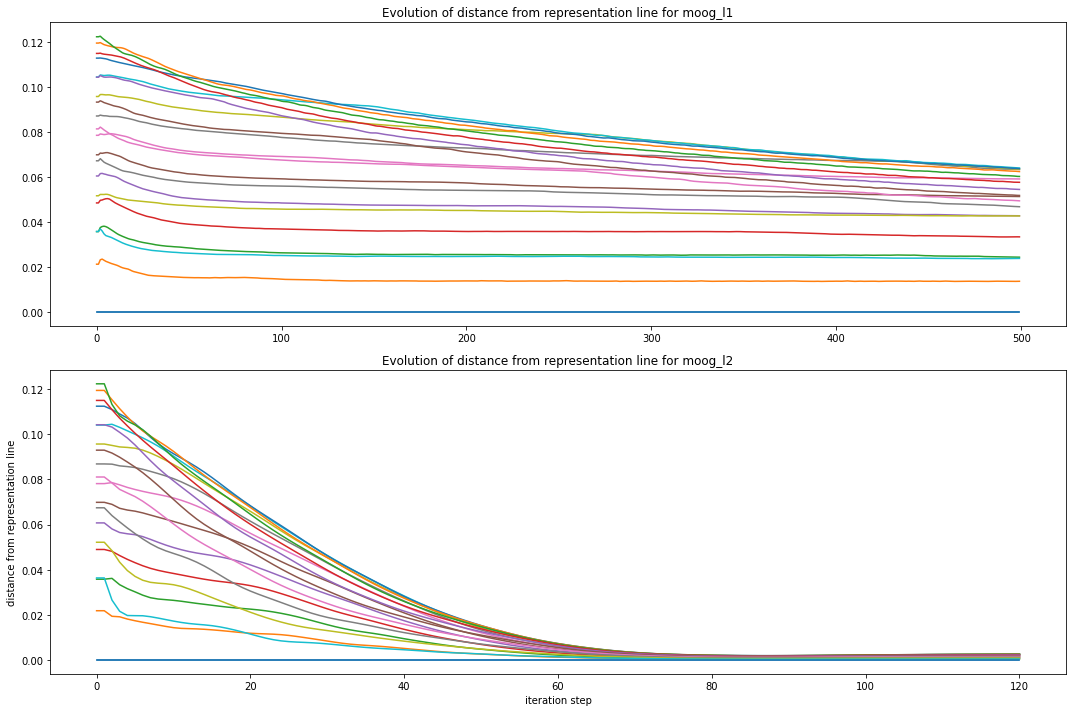

In [23]:
def plotEvolutionFromRepresentationLine(geodesics=geodesics):
    num_loss_types = len(loss_types)
    fig, axes = plt.subplots(nrows=num_loss_types, ncols=1, figsize=(15, 5 * num_loss_types))

# Check if there is only one type to adjust the indexing
    if num_loss_types == 1:
        axes = [axes]  # This makes indexing consistent below

    for i, (key, geodesic) in enumerate(geodesics.items()):
    # `key` would be 'moog_l1', 'moog_l2', etc.
        axes[i].plot(po.to_numpy(geodesic.dev_from_line[..., 1]))
        axes[i].set_title(f'Evolution of distance from representation line for {key}')

    plt.ylabel('distance from representation line')
    plt.xlabel('iteration step')

    plt.tight_layout()
    plt.show()

plotEvolutionFromRepresentationLine()

Top: l1
 Bottom: l2


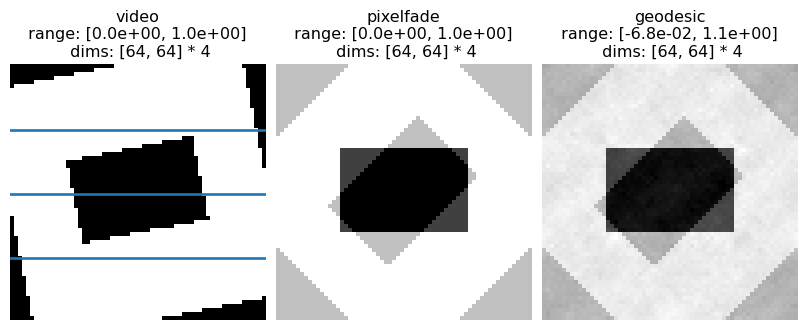

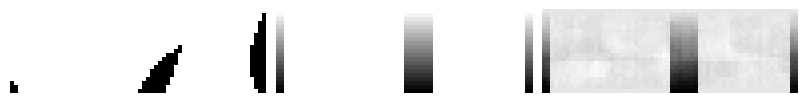

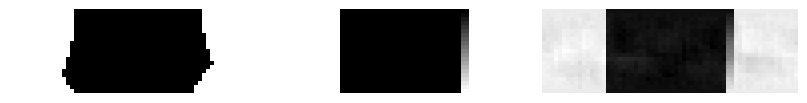

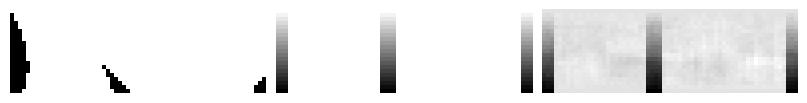

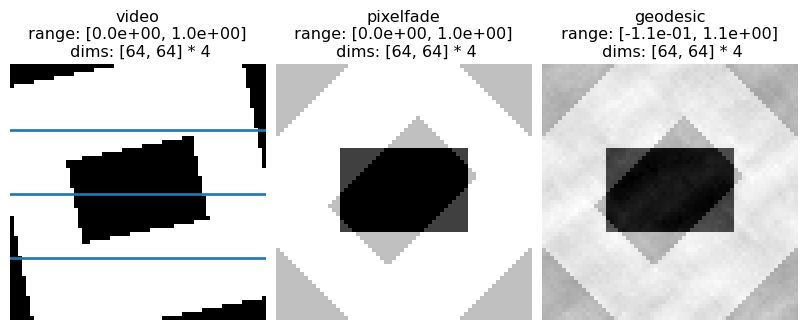

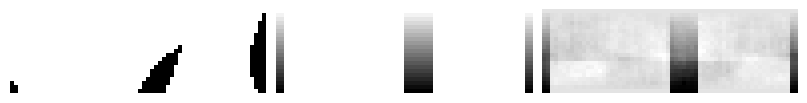

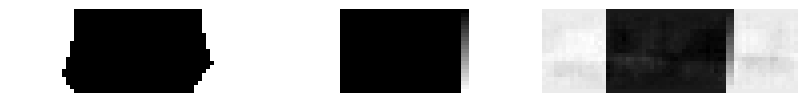

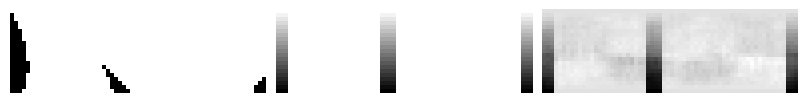

In [34]:
def plotInvariances(geoedescs=geodesics, video=video):
    pixelfade = {}
    geodesic_np = {}

    print(f"Top: {loss_types[0]}\n Bottom: {loss_types[1]}" )
    for loss_type in geodesics.keys():
    # fill pixelfade and geodesic dictionaries

        pixelfade[loss_type] = to_numpy(geodesics[loss_type].pixelfade.squeeze())
        geodesic_np[loss_type] = to_numpy(geodesics[loss_type].geodesic.squeeze())
    #print(f"loss: " , loss_type)
        fig = pt.imshow([video[5], pixelfade[loss_type][5], geodesic_np[loss_type][5]],
          title=['video', 'pixelfade', 'geodesic'],
          col_wrap=3, zoom=4)
        size = geodesic_np[loss_type].shape[-1]
    # for image slices
        h, m, l = (size // 2 + size // 4, size // 2, size // 2 - size // 4)


    # Plot for different horizontal lines in new figures
        a = fig.get_axes()[0]
        for line in (h, m, l):
            a.axhline(line, lw=2)

   

        pt.imshow([video[:, l], pixelfade[loss_type][:, l], geodesic_np[loss_type][:, l]],
            title=None, col_wrap=3, zoom=4)
        pt.imshow([video[:, m], pixelfade[loss_type][:, m], geodesic_np[loss_type][:, m]],
            title=None, col_wrap=3, zoom=4)
        pt.imshow([video[:, h], pixelfade[loss_type][:, h], geodesic_np[loss_type][:, h]],
            title=None, col_wrap=3, zoom=4)

plotInvariances()

Blue: L2 > L1, Red: L1 > L2


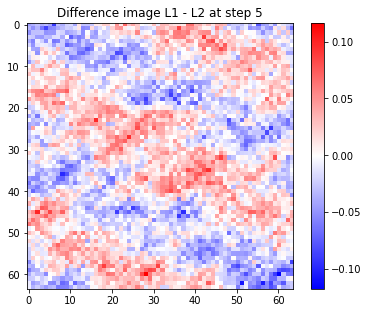

In [25]:

def visualize_difference_image(geodesics=geodesics, nth_step=5):
    geodesic_np = {}
    for g in geodesics.items():
    # fill pixelfade and geodesic dictionaries
        loss_type = g[0]
        #geodesic = g[1]

        geodesic_np[loss_type] = to_numpy(geodesics[loss_type].geodesic.squeeze())
#  difference image between the L1 and L2 geodesic at some number of steps
    diff = geodesic_np["moog_l1"][nth_step] - geodesic_np["moog_l2"][nth_step]
    # Interpretation
    print("Blue: L2 > L1, Red: L1 > L2")
# plot the difference image
    plt.imshow(diff, cmap='bwr')
    plt.colorbar()
    plt.title('Difference image L1 - L2 at step ' + str(nth_step))

visualize_difference_image()

moog_l1
moog_l2


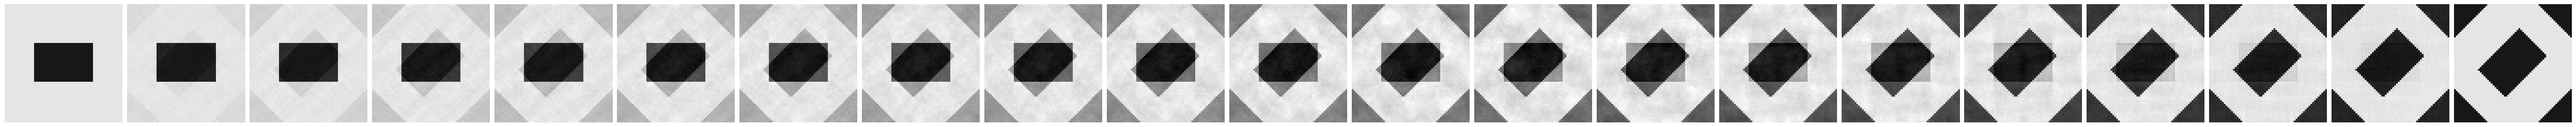

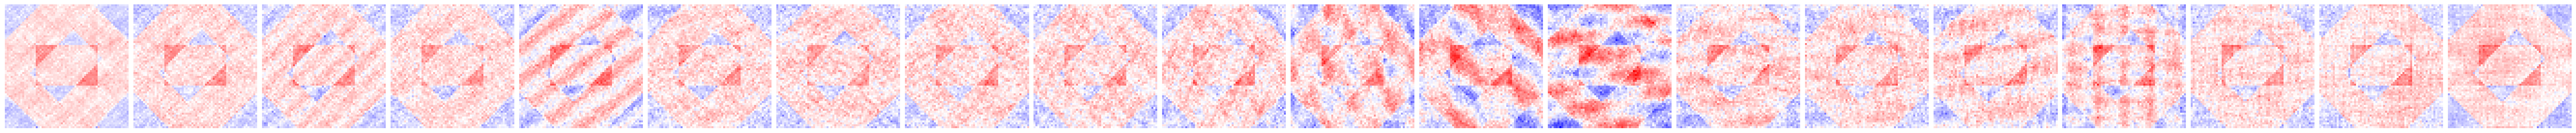

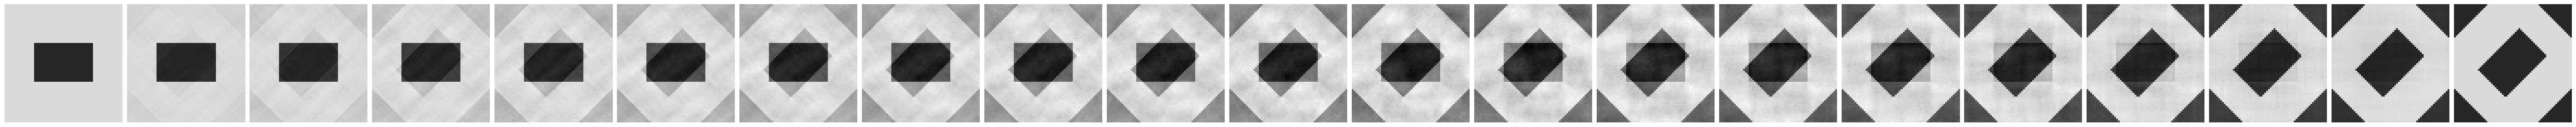

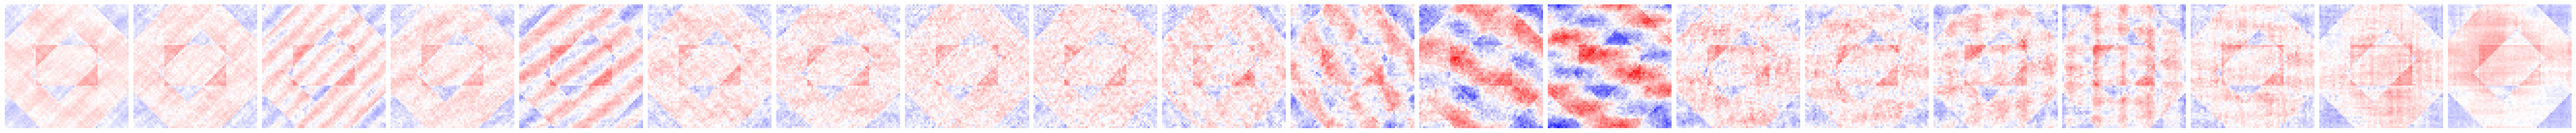

In [40]:

for loss_type in geodesics.keys():
    print(loss_type)
    pt.imshow(list(geodesics[loss_type].geodesic.detach().squeeze()), vrange='auto1', title=None, zoom=4)
    tensor_diffs = geodesics[loss_type].geodesic[1:] - geodesics[loss_type].geodesic[0:-1] 
    pt.imshow(list(tensor_diffs.detach().squeeze()), cmap='bwr', vrange='auto1', title=None, zoom=4)
    
    #pt.imshow(list(geodesics[loss_type].pixelfade.detach().squeeze()), vrange='auto1', title=None, zoom=4)

# print('diff')
# pt.imshow(list(geodesics[loss_type].geodesic - pixelfade), vrange='auto1', title=None, zoom=4);
# print('pixelfade')
# pt.imshow(list(geodesics[loss_type].geodesic), vrange='auto1', title=None, zoom=4);

In [14]:
# check the type of the following: geodesics.items()
geodesics




{}

In [26]:
# TODO: why is geodesics = im_steps all the sudden?
# intermediate steps for printing
im_steps = [1,5,10,15, 19]
# print the intermediate steps for the L1 and L2 geodesic difference images in subplots 
def plotDifferenceSequence(geodesics = geodesics, im_steps=im_steps):
    geodesic_np = {}
    for g in geodesics.items():
    # fill pixelfade and geodesic dictionaries
        loss_type = g[0]
        #geodesic = g[1]

        geodesic_np[loss_type] = to_numpy(geodesics[loss_type].geodesic.squeeze())

    # Interpretation
    print("Blue: L2 > L1, Red: L1 > L2")

    fig, axes = plt.subplots(1, len(im_steps), figsize=(15, 5))
    for i, step in enumerate(im_steps):
        diff = geodesics["moog_l1"][step] - geodesic_np["moog_l2"][step]
        axes[i].imshow(diff, cmap='bwr')
        axes[i].axis('off')
        axes[i].set_title(f'Step {step}')
    # add colorbar to the last subplot
        if i == len(im_steps) - 1:
            plt.colorbar(axes[i].imshow(diff, cmap='seismic'), ax=axes[i])


    plt.show()

plotDifferenceSequence(im_steps)


AttributeError: 'list' object has no attribute 'items'

### Physiologically inspired models

/mnt/home/hdettki/code/plenoptic/src/plenoptic/simulate/models/frontend.py:388: UserWarning: pretrained is True but cache_filt is False. Set cache_filt to True for efficiency unless you are fine-tuning.
  warn("pretrained is True but cache_filt is False. Set cache_filt to "
/mnt/home/hdettki/.virtualenvs/plenoptic/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


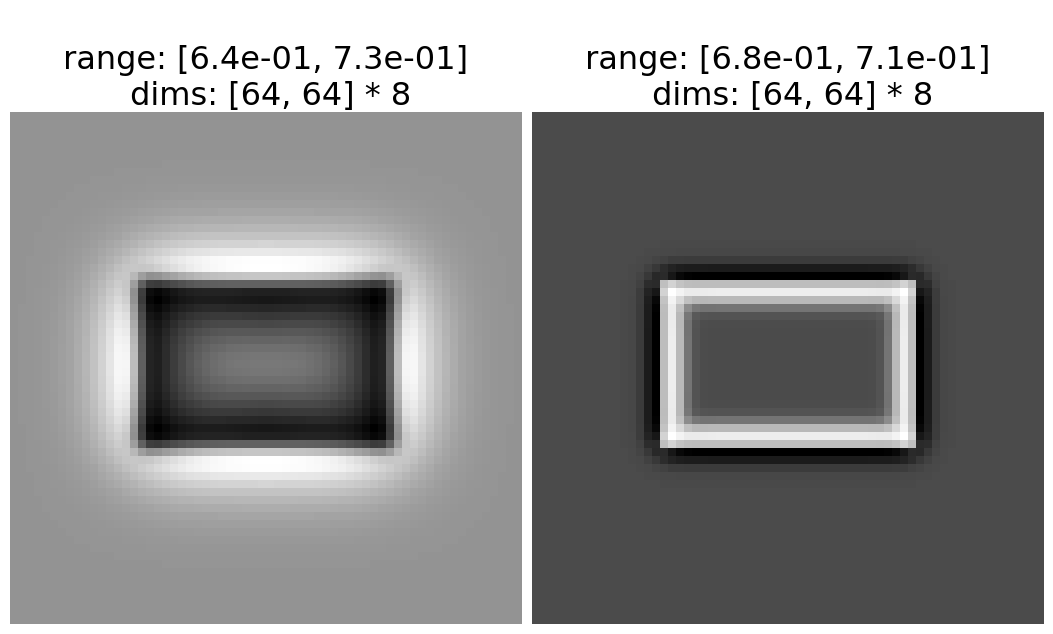

In [27]:
model = po.simul.OnOff(kernel_size=(31,31), pretrained=True)
po.tools.remove_grad(model)
po.imshow(model(imgA), zoom=8);

In [28]:
n_steps = 10
print(imgA.shape)
#moog = po.synth.Geodesic(imgA, imgB, model, n_steps, initial_sequence='bridge', loss_type='l2')
# create the same plots for new model as for Fourier


synthesize_geodesics(n_steps, loss_types, geodesics, optims)


torch.Size([1, 1, 64, 64])


TypeError: 'list' object is not callable

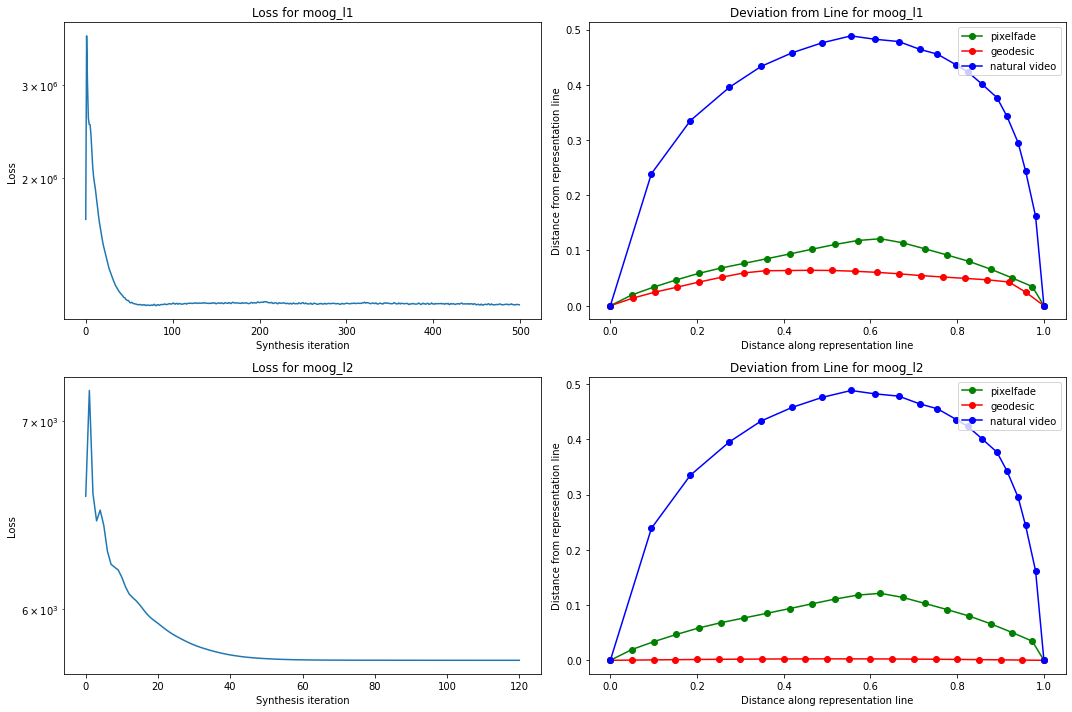

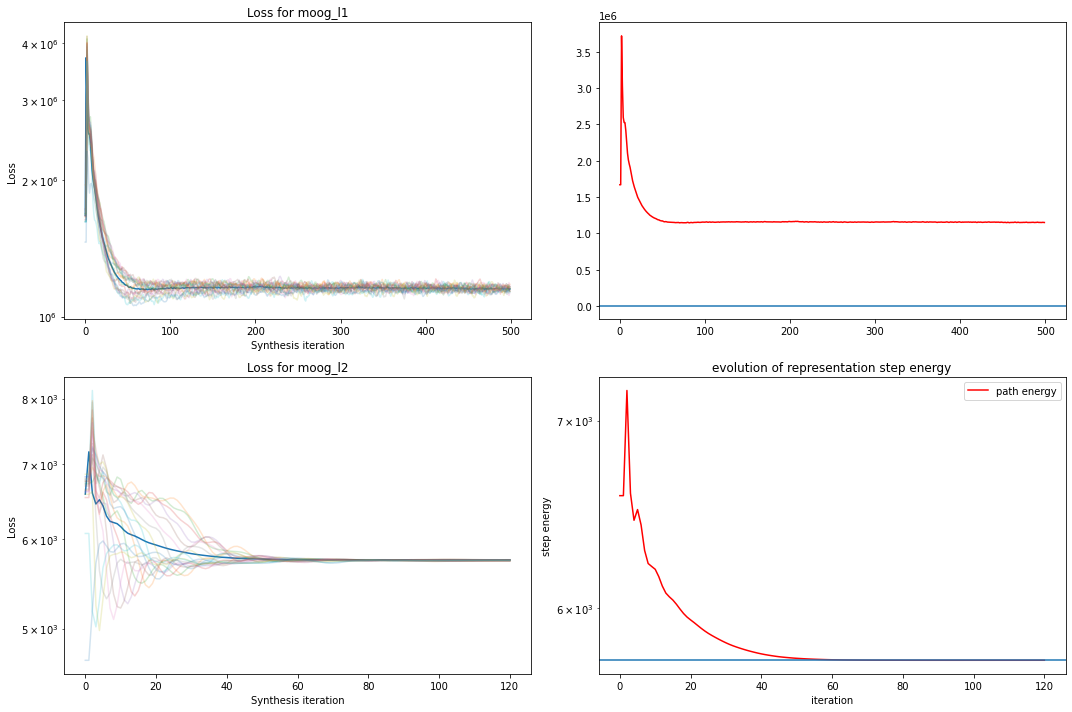

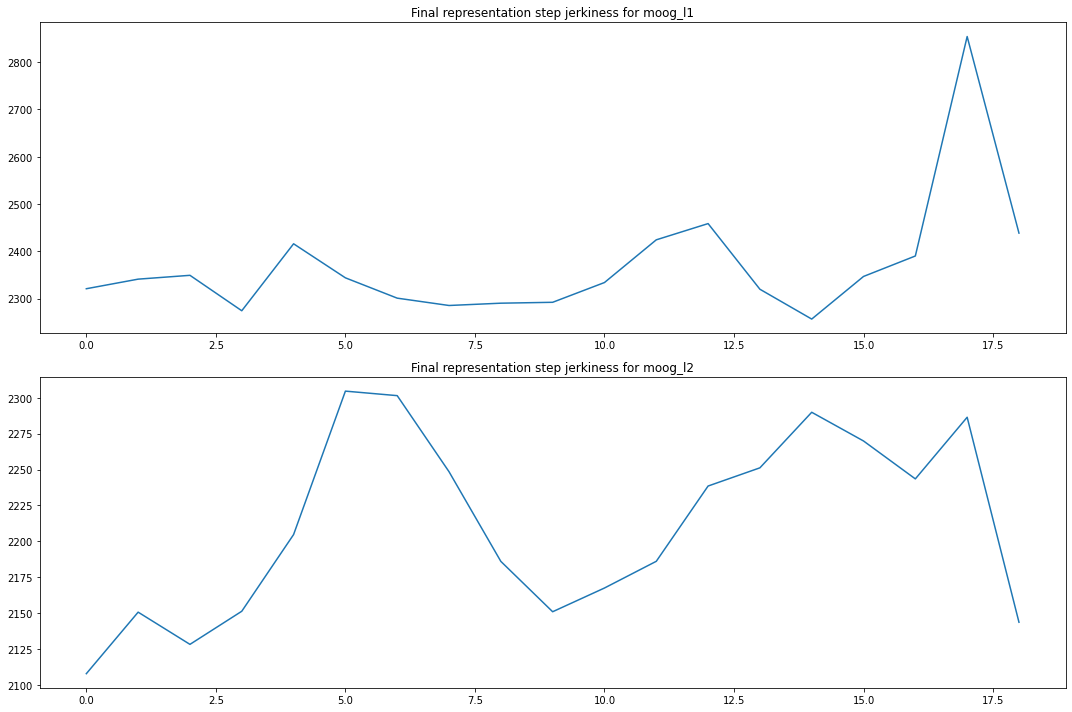

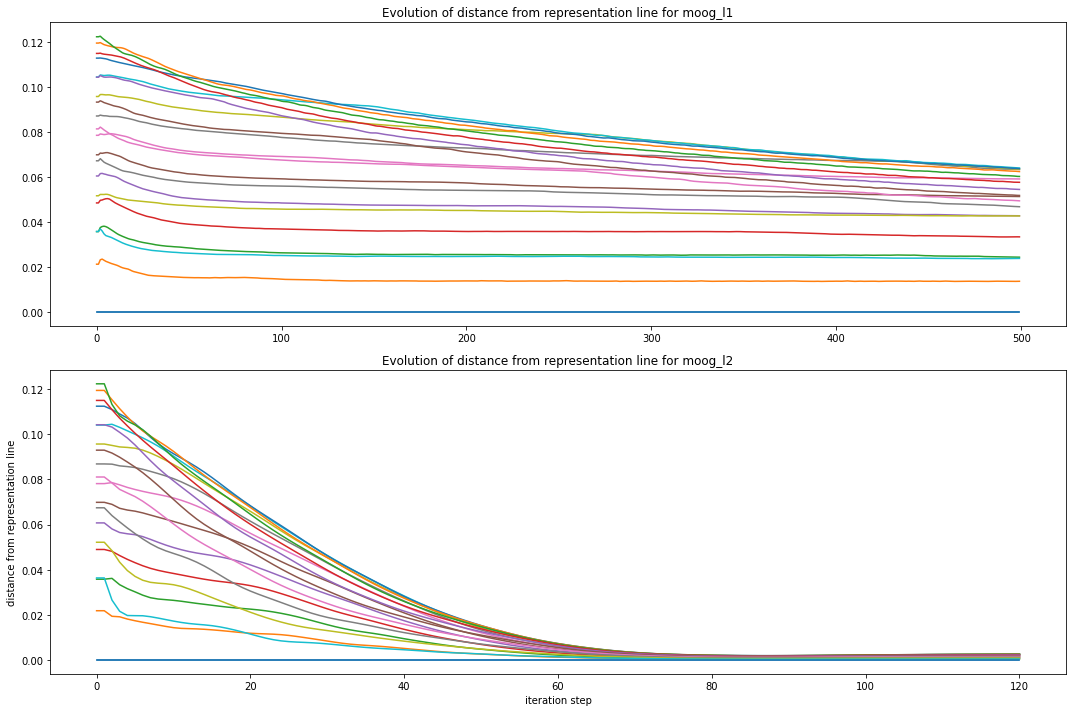

Blue: L2 > L1, Red: L1 > L2


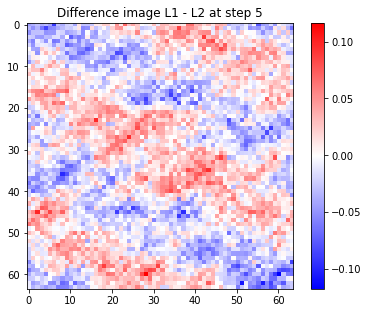

In [29]:
# create same plots for new model as for Fourier
plotLossAndDeviation(geodesics, vid, model, n_steps, loss_types, optims, imgA, imgB)
plotLossAndEvolution(geodesics, vid, model, n_steps, loss_types, optims, imgA, imgB)
plotJerkiness(geodesics)
plotEvolutionFromRepresentationLine(geodesics)
#plotInvariances(geodesics)
visualize_difference_image()

## vgg16: rotation

In [30]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

# load the VGG16 network as used in the paper 
weights = VGG16_Weights.DEFAULT
vgg_model_original = vgg16(weights=weights)
vgg_model_original.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /dev/shm/.cache-hdettki/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 157MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Freezing the base model and cutting of the final layer

In [31]:
vgg_model_original.requires_grad_(False)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Dropping the final layer
We don't want to classify our images, so let's drop all layers starting from the final layer to the penultimate linear layer.

In [32]:
import copy
torch.manual_seed(17)
# copy the vgg model and remove the last layer
vgg_model = copy.deepcopy(vgg_model_original)
# replace the final layer with an identiy layer
#vgg_model.classifier[-1] = nn.Identity()
# drop the final three layers of the network
vgg_model.classifier = vgg_model.classifier[:-3] # we don't want the last three layers (relu, dropout, and fc)
vgg_model.to(device)
# Print the final layer of the VGG model
print("Final layer of VGG model:")
print(vgg_model.classifier[-1])
# print the shape of the final layer
print("Final layer shape:")
print(vgg_model.classifier[-1].out_features)

Final layer of VGG model:
Linear(in_features=4096, out_features=4096, bias=True)
Final layer shape:
4096


In [33]:
# synthesize geodesics for the VGG model
synthesize_geodesics(n_steps,loss_types, geodesics, optims, model=vgg_model)

TypeError: synthesize_geodesics() got multiple values for argument 'model'